# Tomograph Simulation

Simple tomograph simulation for 2d pictures (*.bmp format)

Necessary imports:

In [1]:
%matplotlib inline

In [2]:
from bresenham import bresenham
from PIL import Image
import matplotlib.pyplot as plt
import os
import tomograph_functions as tf

Main parameters to set before computing:

In [20]:
# file name of image to process *.bmp
FILE = "brain.bmp"
# localization in file system
PATH = "pictures"

# number of detectors
detectors_num = 135
# angle between first and last detector
detector_deg = 90
# number of iterations
iterations = 360

Import the image:

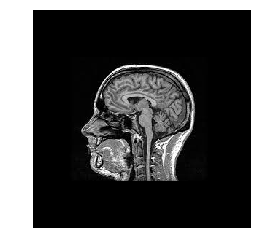

In [8]:
pic_path = os.path.join(PATH, FILE)
img = Image.open(pic_path).convert('L')

new, radius = tf.make_square(img)

plt.imshow(new, cmap='gray')
plt.axis("off")
plt.show()

In [21]:
out = tf.process_cone(detectors_num, detector_deg, iterations, radius, new)

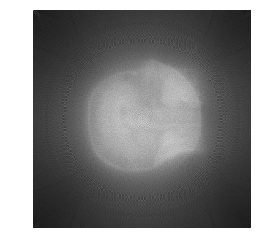

In [22]:
final_image = tf.convert_to_image(out)

plt.imshow(final_image, cmap='gray')
plt.axis("off")
plt.show()